# PyOR also called Python On Resonance
## Author: Vineeth Francis Thalakottoor
## Email: vineeth.thalakottoor@ens.psl.eu or vineethfrancis.physics@gmail.com
## Example: NOE (Liovillie space and Redfield)

### Define the Path to PyOR source code << PythonOnResonance.py >>

In [1]:
SourcePath = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/Source'

### Load Python packages

In [2]:
import sys
sys.path.append(SourcePath)

import PythonOnResonance_jeener_0_9_0 as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib ipympl
import sympy as sp
from sympy import *

### Define Spin System (Two Spin Half)

In [3]:
# Spin_list = [1/2] # Spin half
Spin_list = [1/2, 1/2] # Two spin half
# Spin_list = [1/2,1] # Spin half and spin one
# Spin_list = [1/2,1/2,1/2] # Three spin half
# Spin_list = [1/2,1/2,1/2,1/2] # Four spin half
# Define your own spin system

### Call PyOR Module

In [4]:
System = PyOR.Numerical_MR(Spin_list)


PyOR default parameters/settings
--------------------------------

Define energy units: hbarEQ1 =  True

Define the matrix tolerence (make matrix elements less than tolarence value to zero): MatrixTolarence =  1e-06

Define the gyromagnetic ratios: Gamma =  [0, 0]

Define the static field along Z: B0 =  None

Define rotating frame frequency: OmegaRF =  [0, 0]

Define the offset frequencies of the spins: Offset =  [0, 0]

Do you want to print the larmor frequency: print_Larmor =  True

Define the J coupling: Jlist = 
 [[0. 0.]
 [0. 0.]]

Define the spin paris dipolar coupled: DipolePairs =  []

Spin temperatures
----------------
Initial spin temperature of individual spins: Ispintemp =  [0, 0]
Final spin temperature of individual spins =  [0, 0]

Define propagation space <<Hilbert>> or <<Liouville>>: PropagationSpace =  Hilbert

Acquisition parameters
---------------------
Define acquisition parameter, dwell time: AcqDT =  0.0001
Define acquisition parameter, sampleing frequency: AcqFS

In [5]:
System.PyOR_About()

PyOR Python On Resonance

Version: Jeener

Motto: Everybody can simulate NMR

Author: Vineeth Francis Thalakottoor

Email: vineethfrancis.physics@gmail.com

Package Versions
--------
Numpy version:  1.26.4
Scipy version:  1.13.1
Sympy version:  1.13.2
Numba version:  0.60.0


### Generate spin operators: Sx, Sy, Sz, Sp and Sm

In [6]:

Sx,Sy,Sz,Sp,Sm = System.GenerateSpinOperators()

### Set parameters

In [7]:
# Master Equation
System.PropagationSpace = "Liouville"
System.MasterEquation = "Redfield"

# Gyromagnetic ratio of individual spins (Gamma[0] corresponds to spin 1)
System.Gamma[0] = System.gammaH1
System.Gamma[1] = System.gammaH1

# B0 Field in Tesla, Static Magnetic field (B0) along Z
System.B0 = 9.4

# Rotating Frame Frequency
System.OmegaRF[0] = -System.gammaH1*System.B0
System.OmegaRF[1] = -System.gammaH1*System.B0

# Offset Frequency in rotating frame (Hz)
System.Offset[0] = 10.0
System.Offset[1] = 50.0

# Define J coupling between Spins (Jlist[i][j], j > i)
System.Jlist[0][1] = 5.0

# Define paris of spins coupled by dipolar interaction
System.DipolePairs = [(0,1)]

# Define initial and final Spin Temperature
System.Ispintemp[0] = 300.0
System.Ispintemp[1] = 300.0
System.Fspintemp[0] = 300.0
System.Fspintemp[1] = 300.0

# Relaxation Process
System.Rprocess = "Auto-correlated Dipolar Homonuclear"
System.RelaxParDipole_tau = 10.0e-12
System.RelaxParDipole_bIS = [30.0e3]

### product operator basis (Shift Z or PMZ basis)

In [8]:
sort = 'negative to positive'
Index = False
Normal = True
Basis_PMZ, coh_PMZ, dic_PMZ = System.ProductOperators_SpinHalf_PMZ(sort,Index,Normal)

### Generate Hamiltonians

In [9]:
# generate Larmor Frequencies
LarmorF = System.LarmorFrequency()

# Lab Frame Hamiltonian
Hz_lab = System.Zeeman()

# Rotating Frame Hamiltonian
Hz = System.Zeeman_RotFrame()

# J coupling Hamiltonian
#Hj = System.Jcoupling()
Hj = System.Jcoupling_Weak()

# Generate Commutation Superoperator
Hz_L = System.CommutationSuperoperator(Hz+Hj)

Larmor Frequency in MHz:  [-400.22802765 -400.22806765]


### Initialize Density Matrix

In [10]:
Thermal_DensMatrix = False

if Thermal_DensMatrix:    
    # High Temperature
    HT_approx = False
    
    # Initial Density Matrix
    rho_in = System.EqulibriumDensityMatrix(System.Ispintemp,HT_approx)
    
    # Equlibrium Density Matrix
    rhoeq = System.EqulibriumDensityMatrix(System.Fspintemp,HT_approx)
else:
    rho_in = np.sum(Sz,axis=0)
    rhoeq = np.sum(Sz,axis=0)

System.DensityMatrix_Components_Dictionary(Basis_PMZ,dic_PMZ,rho_in)   

# Converting to Liouville
rho_in_L = System.Vector_L(rho_in)
rhoeq_L = System.Vector_L(rhoeq)

Density Matrix = 1.0 Iz1 Id2  + 1.0 Id1 Iz2 


### Pulse

In [11]:
flip_angle1 = 0.0   # Flip angle Spin 1
flip_angle2 = 180.0 # Flip angle Spin 2

rho_L = System.Rotate_Pulse(rho_in_L,flip_angle1,Sy[0])
rho_L = System.Rotate_Pulse(rho_L,flip_angle2,Sy[1])

## Evolution 

In [12]:
System.AcqDT = 0.0001
System.AcqAQ = 30.0
System.PropagationMethod = "Relaxation"

# Relaxation Superoperator
R_L = System.Relaxation()

start_time = time.time()
t, rho_t = System.Evolution(rhoeq_L,rho_L,Hz_L,R_L)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Total time = 1.4336907863616943 seconds 


### Expectation Value

In [13]:
EXP_Z1 = Sz[0]
EXP_Z2 = Sz[1]

LEXP_Z1 = System.Detection_L(EXP_Z1)
LEXP_Z2 = System.Detection_L(EXP_Z2)

t, Mz1 = System.Expectation(rho_t,LEXP_Z1)
t, Mz2 = System.Expectation(rho_t,LEXP_Z2)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


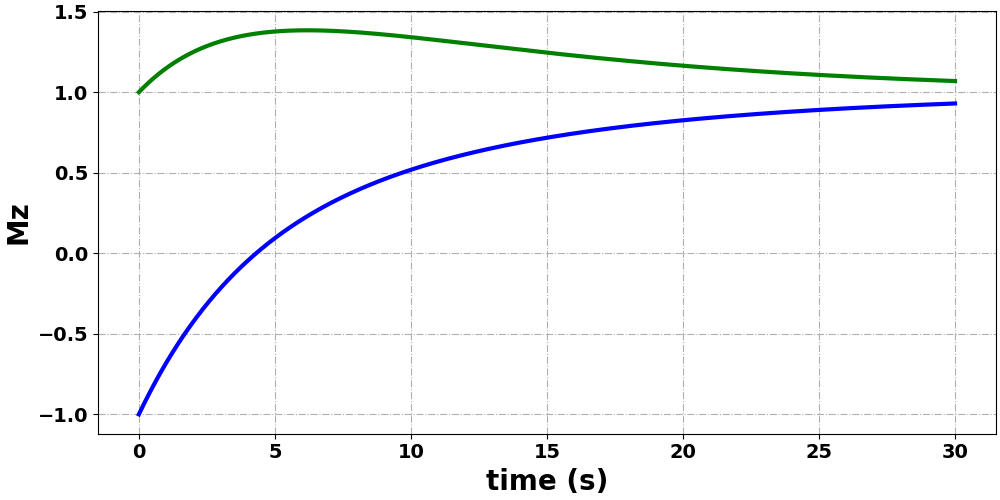

In [14]:
System.PlotFigureSize = (10,5)
System.PlotFontSize = 20
System.PlottingMulti(1,[t,t],[Mz1,Mz2],"time (s)","Mz",["green","blue"])